### Biblioteker

In [138]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact
import ipywidgets as widgets

%reload_ext autoreload
%autoreload 2
from src import *

### Laste inn og gjennomsnittsberegne spektrale kalibreringsbilder

In [139]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

PixelWidth = 1936
PixelHeight = 1216

# Construct paths to the .bip files for each dataset
H_paths = glob.glob(os.path.join(notebook_dir, 'Data', 'H', '*.bip'))  # Eksponering 50 ms
He_paths = glob.glob(os.path.join(notebook_dir, 'Data', 'HE', '*.bip'))  # Eksponering 30 ms
Hg_paths = glob.glob(os.path.join(notebook_dir, 'Data', 'HG', '*.bip'))  # Eksponering 100 ms

# Construct paths relative to the notebook's directory
H_avg_img_path = os.path.join(notebook_dir, 'Data', 'Average', 'H_avg.txt')
He_avg_img_path = os.path.join(notebook_dir,'Data', 'Average', 'He_avg.txt')
Hg_avg_img_path = os.path.join(notebook_dir, 'Data', 'Average', 'Hg_avg.txt')

## Calculate average images for each dataset and save them as .txt files (this is done only once)
#utils.calculate_average_image(H_paths, H_avg_img_path, PixelWidth, PixelHeight)
#utils.calculate_average_image(He_paths, He_avg_img_path, PixelWidth, PixelHeight)
#utils.calculate_average_image(Hg_paths, Hg_avg_img_path, PixelWidth, PixelHeight)

In [140]:
# Read average images
H_avg_img = np.loadtxt(H_avg_img_path, delimiter=',')
He_avg_img = np.loadtxt(He_avg_img_path, delimiter=',')
Hg_avg_img = np.loadtxt(Hg_avg_img_path, delimiter=',')

### Identifisering av pikselverdier ved kjente bølgelengder

In [141]:
img = He_avg_img # Choose image to display

threshold = np.percentile(img, 99) 
spectral_lines = np.where(img > threshold)

unique_x_values = np.unique(spectral_lines[1])
spectralPeaks = utils.find_consecutive_range_means(unique_x_values) # Approximate spectral peaks
print("Spectral Peaks: ", spectralPeaks)

def plot_image(xline=0, yline=0):
    plt.figure(figsize=(30, 14))
    plt.imshow(img, cmap='gray', extent=[0, img.shape[1], 0, img.shape[0]])
    plt.colorbar()
    plt.title('16-bit Image')
    plt.xticks(np.arange(0, img.shape[1], 100))
    plt.axvline(x=xline, color='red')  # Add vertical line at xline
    plt.axhline(y=yline, color='blue')
    plt.show()

# Create interactive widgets for x and y coordinates, pixel width, and pixel height
x_widget = widgets.IntText(value=100, description='X Line:')
y_widget = widgets.IntText(value=681, description='Y Line:')

# Use interact to create the interactive plot
interact(plot_image, xline=x_widget, yline=y_widget)

Spectral Peaks:  [17.0, 434.0, 484.5, 651.0, 720.5, 869.0, 942.0, 1050.0, 1680.0]


interactive(children=(IntText(value=100, description='X Line:'), IntText(value=681, description='Y Line:'), Ou…

<function __main__.plot_image(xline=0, yline=0)>

#### Estimere og lagre piksel til bølgelengde korrelasjon

   Degree     RMS Error
0       1  1.214138e-01
1       2  3.393595e-02
2       3  3.152256e-02
3       4  1.174623e-02
4       5  2.870452e-13


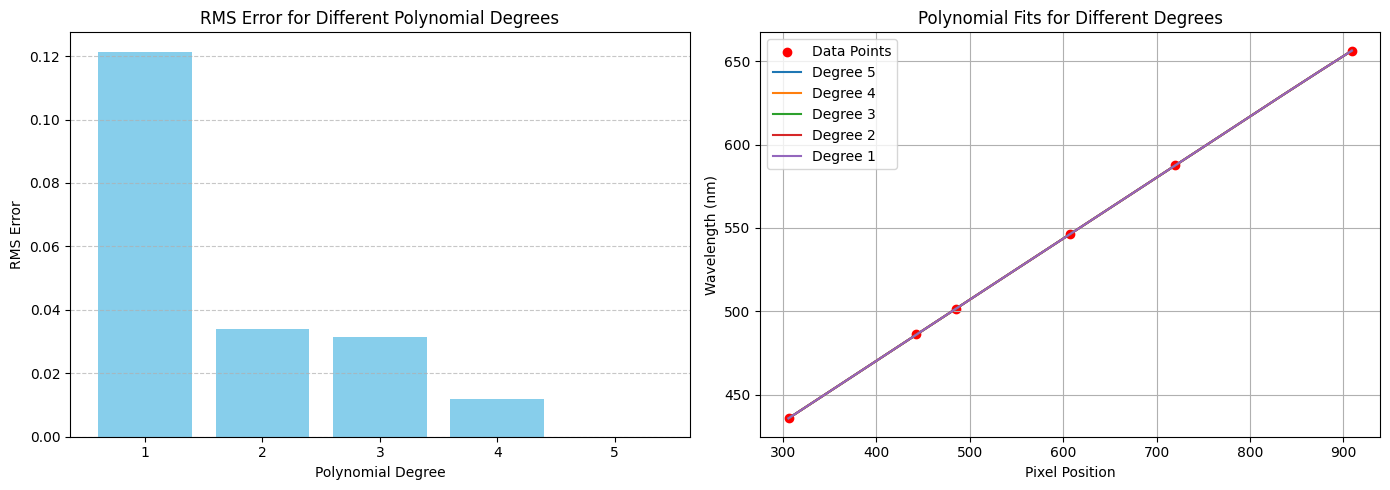

In [142]:
Spectral_lines = [486.1, 656.3, 501.5, 587.5, 435.8, 546.1] # 2 Hydrogen (H), 2 Helium (He), 2 Mercury (Hg)
pixel_positions = [443, 909, 485, 720, 306, 607] 

degrees = range(1, 6)  # Example: degrees from 1 to 5

# Perform polynomial fit for each degree and calculate RMS error
rms_errors = {}
polynomials = {}
for degree in degrees:
    # Perform the calibration
    coefficients = np.polyfit(pixel_positions, Spectral_lines, degree)
    polynomial = np.poly1d(coefficients)
    polynomials[degree] = polynomial
    
    # Predict the wavelengths using the polynomial
    predicted_wavelengths = polynomial(pixel_positions)
    
    # Calculate the RMS error
    rms_error = utils.calculate_rms(Spectral_lines, predicted_wavelengths)
    rms_errors[degree] = rms_error

#print("Polynomial Coefficients: ", polynomials[2].coeffs)
# Create a DataFrame to display the RMS errors in a table
rms_df = pd.DataFrame(list(rms_errors.items()), columns=['Degree', 'RMS Error'])
print(rms_df)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot the RMS errors as a bar chart
axs[0].bar(rms_df['Degree'], rms_df['RMS Error'], color='skyblue')
axs[0].set_xlabel('Polynomial Degree')
axs[0].set_ylabel('RMS Error')
axs[0].set_title('RMS Error for Different Polynomial Degrees')
axs[0].set_xticks(rms_df['Degree'])
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot the original data points and polynomial fits
axs[1].scatter(pixel_positions, Spectral_lines, color='red', label='Data Points')

# Plot the polynomial fits with different line thicknesses, thickest lines first
x_range = np.linspace(min(pixel_positions), max(pixel_positions), 500)
for degree in sorted(polynomials.keys(), reverse=True):
    axs[1].plot(x_range, polynomial(x_range), label=f'Degree {degree}')

axs[1].set_xlabel('Pixel Position')
axs[1].set_ylabel('Wavelength (nm)')
axs[1].set_title('Polynomial Fits for Different Degrees')
axs[1].legend()
axs[1].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [143]:
degree = 2 # Degree of desired polynomial fit
output_file = os.path.join(notebook_dir, 'Data', 'Calibrated', 'calibrated_wavelengths.csv')

df = calibration.calibrate_wavelengths(PixelWidth, Spectral_lines, pixel_positions, degree, output_file)

### FWHM 

In [144]:
# Compute the FWHM for the first three orders
orders = [1, 2, 3]

theoretical_fwhm_values = [utils.theoretical_fwhm(order)*1e9 for order in orders] 

# Create a DataFrame to display the FWHM values
fwhm_df = pd.DataFrame(list(zip(orders, theoretical_fwhm_values)), columns=['Order', 'FWHM [nm]'])
print(fwhm_df)

   Order  FWHM [nm]
0      1   1.388889
1      2   0.694444
2      3   0.462963


   Peak Wavelength [nm]  FWHM [nm]
0            435.428347   4.043608
1            545.425565   3.291483
2            576.854067   4.016994


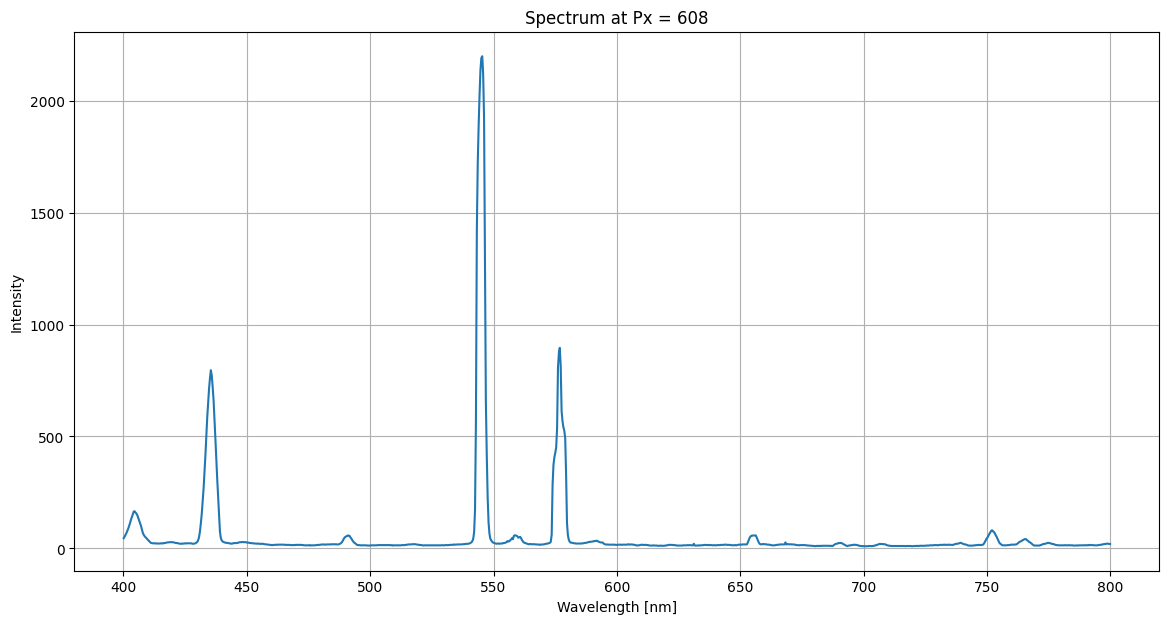

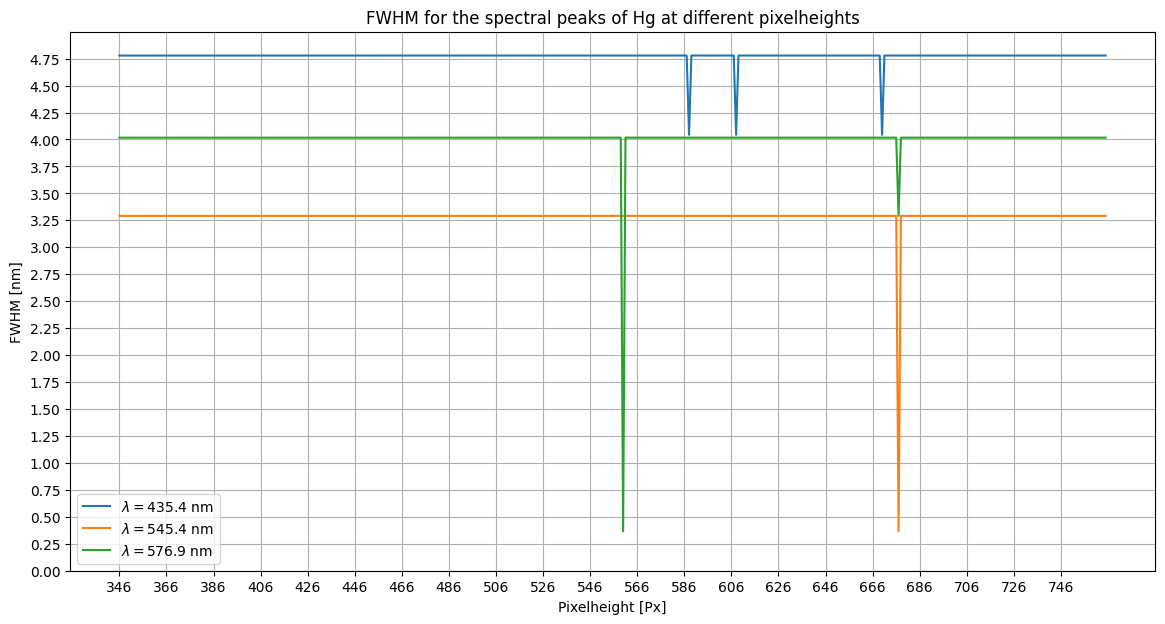

In [157]:
HgSpec, HgWave = calibration.pix_to_wavelength(Hg_avg_img)

# Create a DataFrame to display the peaks and their FWHM values
peaks_wavelengths, fwhm_values = utils.find_peaks_and_fwhm(HgWave, HgSpec[608,:])
fwhm_df = pd.DataFrame(list(zip(peaks_wavelengths, fwhm_values)), columns=['Peak Wavelength [nm]', 'FWHM [nm]'])
print(fwhm_df)


# Initialize an empty list to store FWHM values
fwhm_arr1 = []
fwhm_arr2 = []
fwhm_arr3 = []

# Loop through the specified range of rows
for i in range(346, 766):
    peaks_wavelengths, fwhm_v = utils.find_peaks_and_fwhm(HgWave, HgSpec[i, :])
    fwhm_arr1.append(fwhm_v[0])
    fwhm_arr2.append(fwhm_v[1])
    fwhm_arr3.append(fwhm_v[2])
   
plt.figure(figsize=(14, 7))
plt.plot(HgWave, HgSpec[608, :])
plt.xlabel('Wavelength [nm]')
plt.ylabel('Intensity')
plt.title('Spectrum at Px = 608')
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(np.arange(346, 766),fwhm_arr1, label=r'$\lambda = 435.4$ nm')
plt.plot(np.arange(346, 766),fwhm_arr2, label=r'$\lambda = 545.4$ nm')
plt.plot(np.arange(346, 766),fwhm_arr3, label=r'$\lambda = 576.9$ nm')
plt.xlabel('Pixelheight [Px]')
plt.ylabel('FWHM [nm]')
plt.title('FWHM for the spectral peaks of Hg at different pixelheights')
plt.xticks(np.arange(346, 766, 20))
plt.yticks(np.arange(0, 5, 0.25))
plt.legend()
plt.grid(True)
plt.show()

### Test

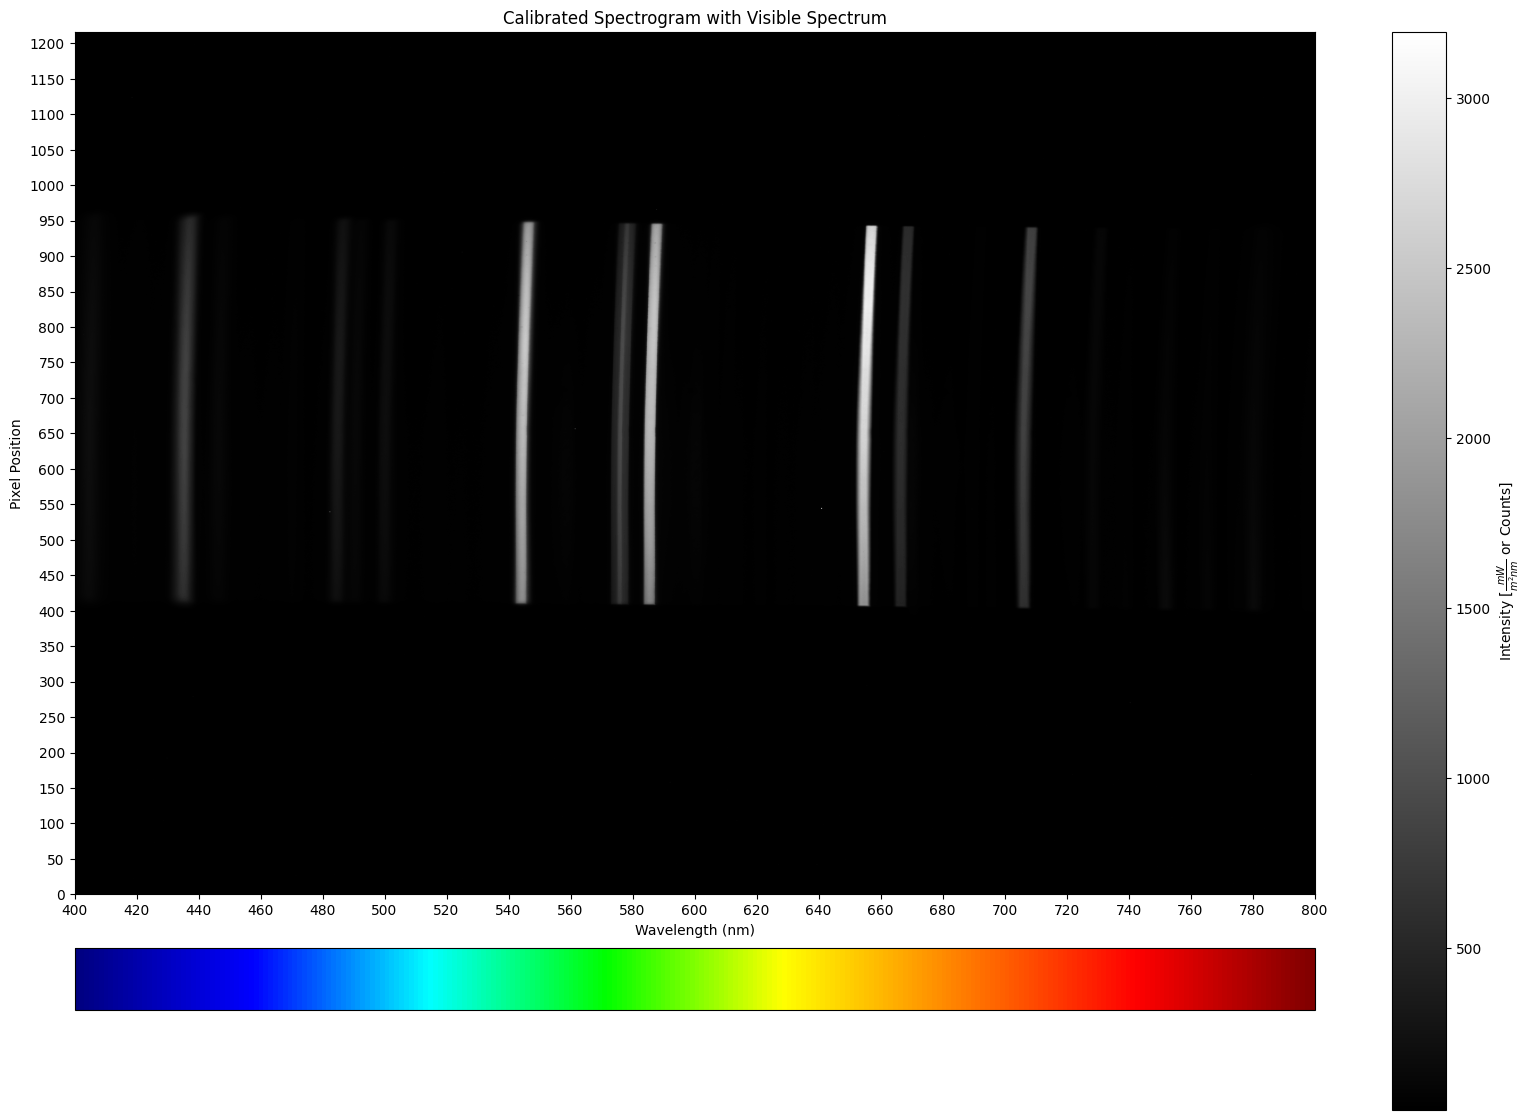

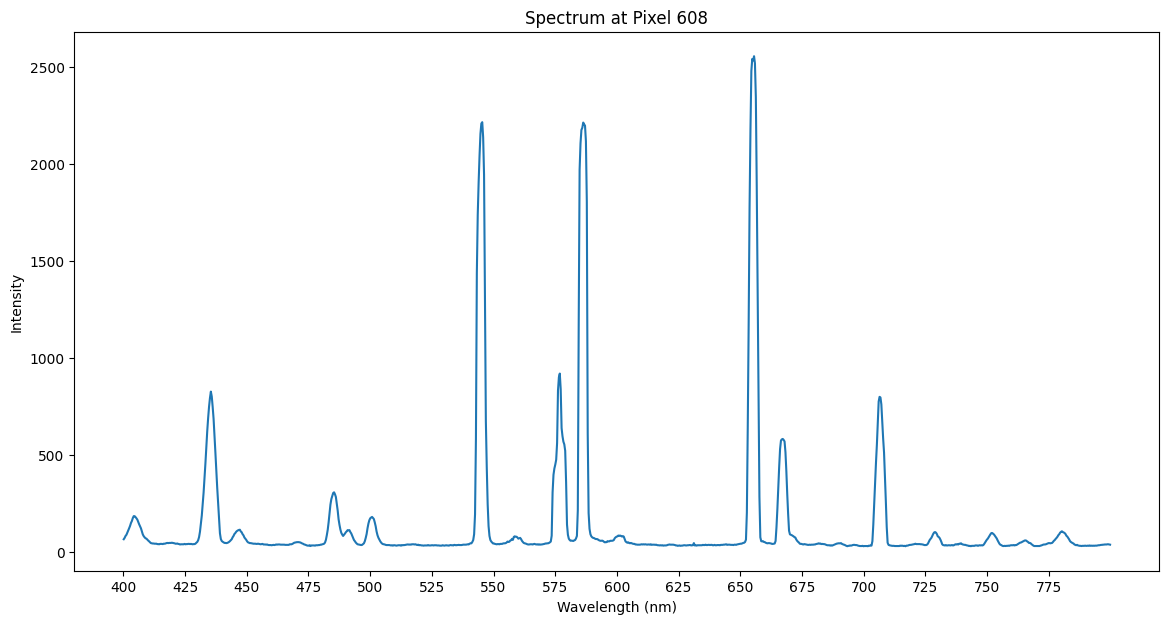

In [146]:
im =  H_avg_img + He_avg_img + Hg_avg_img ## Spectral_lines = [486.1, 656.3, 501.5, 587.5, 435.8, 546.1] # 2 Hydrogen (H), 2 Helium (He), 2 Mercury (Hg)
spec, wave = calibration.pix_to_wavelength(im)
visualization.plot_visible_spectrum_cmap(spec, wave)

plt.figure(figsize=(14, 7))
plt.plot(wave, spec[608,:])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.title('Spectrum at Pixel 608')
plt.xticks(np.arange(400, 800, 25))
plt.show()